In [23]:
# coding=utf-8
# Copyright 2022 The HuggingFace Inc. team. All rights reserved.
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" PyTorch Time Series Transformer model."""

# coding=utf-8
# Copyright 2022 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Time Series Transformer model configuration"""

from typing import List, Optional, Union

from ...configuration_utils import PretrainedConfig
from ...utils import logging

from typing import List, Optional, Tuple, Union

import numpy as np
import torch
from torch import nn

from ...activations import ACT2FN
from ...modeling_attn_mask_utils import _prepare_4d_attention_mask, _prepare_4d_causal_attention_mask
from ...modeling_outputs import (
    BaseModelOutput,
    BaseModelOutputWithPastAndCrossAttentions,
    SampleTSPredictionOutput,
    Seq2SeqTSModelOutput,
    Seq2SeqTSPredictionOutput,
)
from ...modeling_utils import PreTrainedModel
from ...time_series_utils import NegativeBinomialOutput, NormalOutput, StudentTOutput
from ...utils import add_start_docstrings, add_start_docstrings_to_model_forward, logging, replace_return_docstrings
from .configuration_time_series_transformer import TimeSeriesTransformerConfig


logger = logging.get_logger(__name__)

TIME_SERIES_TRANSFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP = {
    "huggingface/time-series-transformer-tourism-monthly": (
        "https://huggingface.co/huggingface/time-series-transformer-tourism-monthly/resolve/main/config.json"
    ),
    # See all TimeSeriesTransformer models at https://huggingface.co/models?filter=time_series_transformer
}


class TimeSeriesTransformerConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`TimeSeriesTransformerModel`]. It is used to
    instantiate a Time Series Transformer model according to the specified arguments, defining the model architecture.
    Instantiating a configuration with the defaults will yield a similar configuration to that of the Time Series
    Transformer
    [huggingface/time-series-transformer-tourism-monthly](https://huggingface.co/huggingface/time-series-transformer-tourism-monthly)
    architecture.

    Configuration objects inherit from [`PretrainedConfig`] can be used to control the model outputs. Read the
    documentation from [`PretrainedConfig`] for more information.

    Args:
        prediction_length (`int`):
            The prediction length for the decoder. In other words, the prediction horizon of the model. This value is
            typically dictated by the dataset and we recommend to set it appropriately.
        context_length (`int`, *optional*, defaults to `prediction_length`):
            The context length for the encoder. If `None`, the context length will be the same as the
            `prediction_length`.
        distribution_output (`string`, *optional*, defaults to `"student_t"`):
            The distribution emission head for the model. Could be either "student_t", "normal" or "negative_binomial".
        loss (`string`, *optional*, defaults to `"nll"`):
            The loss function for the model corresponding to the `distribution_output` head. For parametric
            distributions it is the negative log likelihood (nll) - which currently is the only supported one.
        input_size (`int`, *optional*, defaults to 1):
            The size of the target variable which by default is 1 for univariate targets. Would be > 1 in case of
            multivariate targets.
        scaling (`string` or `bool`, *optional* defaults to `"mean"`):
            Whether to scale the input targets via "mean" scaler, "std" scaler or no scaler if `None`. If `True`, the
            scaler is set to "mean".
        lags_sequence (`list[int]`, *optional*, defaults to `[1, 2, 3, 4, 5, 6, 7]`):
            The lags of the input time series as covariates often dictated by the frequency of the data. Default is
            `[1, 2, 3, 4, 5, 6, 7]` but we recommend to change it based on the dataset appropriately.
        num_time_features (`int`, *optional*, defaults to 0):
            The number of time features in the input time series.
        num_dynamic_real_features (`int`, *optional*, defaults to 0):
            The number of dynamic real valued features.
        num_static_categorical_features (`int`, *optional*, defaults to 0):
            The number of static categorical features.
        num_static_real_features (`int`, *optional*, defaults to 0):
            The number of static real valued features.
        cardinality (`list[int]`, *optional*):
            The cardinality (number of different values) for each of the static categorical features. Should be a list
            of integers, having the same length as `num_static_categorical_features`. Cannot be `None` if
            `num_static_categorical_features` is > 0.
        embedding_dimension (`list[int]`, *optional*):
            The dimension of the embedding for each of the static categorical features. Should be a list of integers,
            having the same length as `num_static_categorical_features`. Cannot be `None` if
            `num_static_categorical_features` is > 0.
        d_model (`int`, *optional*, defaults to 64):
            Dimensionality of the transformer layers.
        encoder_layers (`int`, *optional*, defaults to 2):
            Number of encoder layers.
        decoder_layers (`int`, *optional*, defaults to 2):
            Number of decoder layers.
        encoder_attention_heads (`int`, *optional*, defaults to 2):
            Number of attention heads for each attention layer in the Transformer encoder.
        decoder_attention_heads (`int`, *optional*, defaults to 2):
            Number of attention heads for each attention layer in the Transformer decoder.
        encoder_ffn_dim (`int`, *optional*, defaults to 32):
            Dimension of the "intermediate" (often named feed-forward) layer in encoder.
        decoder_ffn_dim (`int`, *optional*, defaults to 32):
            Dimension of the "intermediate" (often named feed-forward) layer in decoder.
        activation_function (`str` or `function`, *optional*, defaults to `"gelu"`):
            The non-linear activation function (function or string) in the encoder and decoder. If string, `"gelu"` and
            `"relu"` are supported.
        dropout (`float`, *optional*, defaults to 0.1):
            The dropout probability for all fully connected layers in the encoder, and decoder.
        encoder_layerdrop (`float`, *optional*, defaults to 0.1):
            The dropout probability for the attention and fully connected layers for each encoder layer.
        decoder_layerdrop (`float`, *optional*, defaults to 0.1):
            The dropout probability for the attention and fully connected layers for each decoder layer.
        attention_dropout (`float`, *optional*, defaults to 0.1):
            The dropout probability for the attention probabilities.
        activation_dropout (`float`, *optional*, defaults to 0.1):
            The dropout probability used between the two layers of the feed-forward networks.
        num_parallel_samples (`int`, *optional*, defaults to 100):
            The number of samples to generate in parallel for each time step of inference.
        init_std (`float`, *optional*, defaults to 0.02):
            The standard deviation of the truncated normal weight initialization distribution.
        use_cache (`bool`, *optional*, defaults to `True`):
            Whether to use the past key/values attentions (if applicable to the model) to speed up decoding.

        Example:

    ```python
    >>> from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

    >>> # Initializing a Time Series Transformer configuration with 12 time steps for prediction
    >>> configuration = TimeSeriesTransformerConfig(prediction_length=12)

    >>> # Randomly initializing a model (with random weights) from the configuration
    >>> model = TimeSeriesTransformerModel(configuration)

    >>> # Accessing the model configuration
    >>> configuration = model.config
    ```"""
    model_type = "time_series_transformer"
    attribute_map = {
        "hidden_size": "d_model",
        "num_attention_heads": "encoder_attention_heads",
        "num_hidden_layers": "encoder_layers",
    }

    def __init__(
        self,
        prediction_length: Optional[int] = None,
        context_length: Optional[int] = None,
        distribution_output: str = "student_t",
        loss: str = "nll",
        input_size: int = 1,
        lags_sequence: List[int] = [1, 2, 3, 4, 5, 6, 7],
        scaling: Optional[Union[str, bool]] = "mean",
        num_dynamic_real_features: int = 0,
        num_static_categorical_features: int = 0,
        num_static_real_features: int = 0,
        num_time_features: int = 0,
        cardinality: Optional[List[int]] = None,
        embedding_dimension: Optional[List[int]] = None,
        encoder_ffn_dim: int = 32,
        decoder_ffn_dim: int = 32,
        encoder_attention_heads: int = 2,
        decoder_attention_heads: int = 2,
        encoder_layers: int = 2,
        decoder_layers: int = 2,
        is_encoder_decoder: bool = True,
        activation_function: str = "gelu",
        d_model: int = 64,
        dropout: float = 0.1,
        encoder_layerdrop: float = 0.1,
        decoder_layerdrop: float = 0.1,
        attention_dropout: float = 0.1,
        activation_dropout: float = 0.1,
        num_parallel_samples: int = 100,
        init_std: float = 0.02,
        use_cache=True,
        **kwargs,
    ):
        # time series specific configuration
        self.prediction_length = prediction_length
        self.context_length = context_length or prediction_length
        self.distribution_output = distribution_output
        self.loss = loss
        self.input_size = input_size
        self.num_time_features = num_time_features
        self.lags_sequence = lags_sequence
        self.scaling = scaling
        self.num_dynamic_real_features = num_dynamic_real_features
        self.num_static_real_features = num_static_real_features
        self.num_static_categorical_features = num_static_categorical_features
        if cardinality and num_static_categorical_features > 0:
            if len(cardinality) != num_static_categorical_features:
                raise ValueError(
                    "The cardinality should be a list of the same length as `num_static_categorical_features`"
                )
            self.cardinality = cardinality
        else:
            self.cardinality = [0]
        if embedding_dimension and num_static_categorical_features > 0:
            if len(embedding_dimension) != num_static_categorical_features:
                raise ValueError(
                    "The embedding dimension should be a list of the same length as `num_static_categorical_features`"
                )
            self.embedding_dimension = embedding_dimension
        else:
            self.embedding_dimension = [min(50, (cat + 1) // 2) for cat in self.cardinality]
        self.num_parallel_samples = num_parallel_samples

        # Transformer architecture configuration
        self.feature_size = input_size * len(lags_sequence) + self._number_of_features
        self.d_model = d_model
        self.encoder_attention_heads = encoder_attention_heads
        self.decoder_attention_heads = decoder_attention_heads
        self.encoder_ffn_dim = encoder_ffn_dim
        self.decoder_ffn_dim = decoder_ffn_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers

        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.activation_dropout = activation_dropout
        self.encoder_layerdrop = encoder_layerdrop
        self.decoder_layerdrop = decoder_layerdrop

        self.activation_function = activation_function
        self.init_std = init_std

        self.use_cache = use_cache

        super().__init__(is_encoder_decoder=is_encoder_decoder, **kwargs)

    @property
    def _number_of_features(self) -> int:
        return (
            sum(self.embedding_dimension)
            + self.num_dynamic_real_features
            + self.num_time_features
            + self.num_static_real_features
            + self.input_size * 2  # the log1p(abs(loc)) and log(scale) features
        )

logger = logging.get_logger(__name__)

_CONFIG_FOR_DOC = "TimeSeriesTransformerConfig"


TIME_SERIES_TRANSFORMER_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "huggingface/time-series-transformer-tourism-monthly",
    # See all TimeSeriesTransformer models at https://huggingface.co/models?filter=time_series_transformer
]


class TimeSeriesFeatureEmbedder(nn.Module):
    """
    Embed a sequence of categorical features.

    Args:
        cardinalities (`list[int]`):
            List of cardinalities of the categorical features.
        embedding_dims (`list[int]`):
            List of embedding dimensions of the categorical features.
    """

    def __init__(self, cardinalities: List[int], embedding_dims: List[int]) -> None:
        super().__init__()

        self.num_features = len(cardinalities)
        self.embedders = nn.ModuleList([nn.Embedding(c, d) for c, d in zip(cardinalities, embedding_dims)])

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        if self.num_features > 1:
            # we slice the last dimension, giving an array of length
            # self.num_features with shape (N,T) or (N)
            cat_feature_slices = torch.chunk(features, self.num_features, dim=-1)
        else:
            cat_feature_slices = [features]

        return torch.cat(
            [
                embed(cat_feature_slice.squeeze(-1))
                for embed, cat_feature_slice in zip(self.embedders, cat_feature_slices)
            ],
            dim=-1,
        )


class TimeSeriesStdScaler(nn.Module):
    """
    Standardize features by calculating the mean and scaling along some given dimension `dim`, and then normalizes it
    by subtracting from the mean and dividing by the standard deviation.

    Args:
        dim (`int`):
            Dimension along which to calculate the mean and standard deviation.
        keepdim (`bool`, *optional*, defaults to `False`):
            Controls whether to retain dimension `dim` (of length 1) in the scale tensor, or suppress it.
        minimum_scale (`float`, *optional*, defaults to 1e-5):
            Default scale that is used for elements that are constantly zero along dimension `dim`.
    """

    def __init__(self, dim: int, keepdim: bool = False, minimum_scale: float = 1e-5):
        super().__init__()
        if not dim > 0:
            raise ValueError("Cannot compute scale along dim = 0 (batch dimension), please provide dim > 0")
        self.dim = dim
        self.keepdim = keepdim
        self.minimum_scale = minimum_scale

    @torch.no_grad()
    def forward(self, data: torch.Tensor, weights: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        denominator = weights.sum(self.dim, keepdim=self.keepdim)
        denominator = denominator.clamp_min(1.0)
        loc = (data * weights).sum(self.dim, keepdim=self.keepdim) / denominator

        variance = (((data - loc) * weights) ** 2).sum(self.dim, keepdim=self.keepdim) / denominator
        scale = torch.sqrt(variance + self.minimum_scale)
        return (data - loc) / scale, loc, scale


class TimeSeriesMeanScaler(nn.Module):
    """
    Computes a scaling factor as the weighted average absolute value along dimension `dim`, and scales the data
    accordingly.

    Args:
        dim (`int`):
            Dimension along which to compute the scale.
        keepdim (`bool`, *optional*, defaults to `False`):
            Controls whether to retain dimension `dim` (of length 1) in the scale tensor, or suppress it.
        default_scale (`float`, *optional*, defaults to `None`):
            Default scale that is used for elements that are constantly zero. If `None`, we use the scale of the batch.
        minimum_scale (`float`, *optional*, defaults to 1e-10):
            Default minimum possible scale that is used for any item.
    """

    def __init__(
        self, dim: int = -1, keepdim: bool = True, default_scale: Optional[float] = None, minimum_scale: float = 1e-10
    ):
        super().__init__()
        self.dim = dim
        self.keepdim = keepdim
        self.minimum_scale = minimum_scale
        self.default_scale = default_scale

    @torch.no_grad()
    def forward(
        self, data: torch.Tensor, observed_indicator: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # shape: (N, [C], T=1)
        ts_sum = (data * observed_indicator).abs().sum(self.dim, keepdim=True)
        num_observed = observed_indicator.sum(self.dim, keepdim=True)

        scale = ts_sum / torch.clamp(num_observed, min=1)

        # If `default_scale` is provided, we use it, otherwise we use the scale
        # of the batch.
        if self.default_scale is None:
            batch_sum = ts_sum.sum(dim=0)
            batch_observations = torch.clamp(num_observed.sum(0), min=1)
            default_scale = torch.squeeze(batch_sum / batch_observations)
        else:
            default_scale = self.default_scale * torch.ones_like(scale)

        # apply default scale where there are no observations
        scale = torch.where(num_observed > 0, scale, default_scale)

        # ensure the scale is at least `self.minimum_scale`
        scale = torch.clamp(scale, min=self.minimum_scale)
        scaled_data = data / scale

        if not self.keepdim:
            scale = scale.squeeze(dim=self.dim)

        return scaled_data, torch.zeros_like(scale), scale


class TimeSeriesNOPScaler(nn.Module):
    """
    Assigns a scaling factor equal to 1 along dimension `dim`, and therefore applies no scaling to the input data.

    Args:
        dim (`int`):
            Dimension along which to compute the scale.
        keepdim (`bool`, *optional*, defaults to `False`):
            Controls whether to retain dimension `dim` (of length 1) in the scale tensor, or suppress it.
    """

    def __init__(self, dim: int, keepdim: bool = False):
        super().__init__()
        self.dim = dim
        self.keepdim = keepdim

    def forward(
        self, data: torch.Tensor, observed_indicator: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        scale = torch.ones_like(data, requires_grad=False).mean(dim=self.dim, keepdim=self.keepdim)
        loc = torch.zeros_like(data, requires_grad=False).mean(dim=self.dim, keepdim=self.keepdim)
        return data, loc, scale


def nll(input: torch.distributions.Distribution, target: torch.Tensor) -> torch.Tensor:
    """
    Computes the negative log likelihood loss from input distribution with respect to target.
    """
    return -input.log_prob(target)


def weighted_average(input_tensor: torch.Tensor, weights: Optional[torch.Tensor] = None, dim=None) -> torch.Tensor:
    """
    Computes the weighted average of a given tensor across a given `dim`, masking values associated with weight zero,
    meaning instead of `nan * 0 = nan` you will get `0 * 0 = 0`.

    Args:
        input_tensor (`torch.FloatTensor`):
            Input tensor, of which the average must be computed.
        weights (`torch.FloatTensor`, *optional*):
            Weights tensor, of the same shape as `input_tensor`.
        dim (`int`, *optional*):
            The dim along which to average `input_tensor`.

    Returns:
        `torch.FloatTensor`: The tensor with values averaged along the specified `dim`.
    """
    if weights is not None:
        weighted_tensor = torch.where(weights != 0, input_tensor * weights, torch.zeros_like(input_tensor))
        sum_weights = torch.clamp(weights.sum(dim=dim) if dim else weights.sum(), min=1.0)
        return (weighted_tensor.sum(dim=dim) if dim else weighted_tensor.sum()) / sum_weights
    else:
        return input_tensor.mean(dim=dim)


# Copied from transformers.models.marian.modeling_marian.MarianSinusoidalPositionalEmbedding with Marian->TimeSeries
class TimeSeriesSinusoidalPositionalEmbedding(nn.Embedding):
    """This module produces sinusoidal positional embeddings of any length."""

    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None) -> None:
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out: nn.Parameter) -> nn.Parameter:
        """
        Identical to the XLM create_sinusoidal_embeddings except features are not interleaved. The cos features are in
        the 2nd half of the vector. [dim // 2:]
        """
        n_pos, dim = out.shape
        position_enc = np.array(
            [[pos / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)] for pos in range(n_pos)]
        )
        out.requires_grad = False  # set early to avoid an error in pytorch-1.8+
        sentinel = dim // 2 if dim % 2 == 0 else (dim // 2) + 1
        out[:, 0:sentinel] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
        out[:, sentinel:] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
        out.detach_()
        return out

    @torch.no_grad()
    def forward(self, input_ids_shape: torch.Size, past_key_values_length: int = 0) -> torch.Tensor:
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids_shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        )
        return super().forward(positions)


class TimeSeriesValueEmbedding(nn.Module):
    def __init__(self, feature_size, d_model):
        super().__init__()
        self.value_projection = nn.Linear(in_features=feature_size, out_features=d_model, bias=False)

    def forward(self, x):
        return self.value_projection(x)


# Copied from transformers.models.bart.modeling_bart.BartAttention with Bart->TimeSeriesTransformer
class TimeSeriesTransformerAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.reshape(*proj_shape)
        value_states = value_states.reshape(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value


# Copied from transformers.models.bart.modeling_bart.BartEncoderLayer with Bart->TimeSeriesTransformer
class TimeSeriesTransformerEncoderLayer(nn.Module):
    def __init__(self, config: TimeSeriesTransformerConfig):
        super().__init__()
        self.embed_dim = config.d_model
        self.self_attn = TimeSeriesTransformerAttention(
            embed_dim=self.embed_dim,
            num_heads=config.encoder_attention_heads,
            dropout=config.attention_dropout,
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, config.encoder_ffn_dim)
        self.fc2 = nn.Linear(config.encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.FloatTensor,
        attention_mask: torch.FloatTensor,
        layer_head_mask: torch.FloatTensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor, Optional[torch.FloatTensor]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states, attn_weights, _ = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs


# Copied from transformers.models.bart.modeling_bart.BartDecoderLayer with Bart->TimeSeriesTransformer
class TimeSeriesTransformerDecoderLayer(nn.Module):
    def __init__(self, config: TimeSeriesTransformerConfig):
        super().__init__()
        self.embed_dim = config.d_model

        self.self_attn = TimeSeriesTransformerAttention(
            embed_dim=self.embed_dim,
            num_heads=config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = TimeSeriesTransformerAttention(
            self.embed_dim,
            config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, config.decoder_ffn_dim)
        self.fc2 = nn.Linear(config.decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = True,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
                size `(decoder_attention_heads,)`.
            past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


class TimeSeriesTransformerPreTrainedModel(PreTrainedModel):
    config_class = TimeSeriesTransformerConfig
    base_model_prefix = "model"
    main_input_name = "past_values"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        std = self.config.init_std
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, TimeSeriesSinusoidalPositionalEmbedding):
            pass
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()


TIME_SERIES_TRANSFORMER_START_DOCSTRING = r"""
    This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
    library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
    etc.)

    This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
    and behavior.

    Parameters:
        config ([`TimeSeriesTransformerConfig`]):
            Model configuration class with all the parameters of the model. Initializing with a config file does not
            load the weights associated with the model, only the configuration. Check out the
            [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

TIME_SERIES_TRANSFORMER_INPUTS_DOCSTRING = r"""
    Args:
        past_values (`torch.FloatTensor` of shape `(batch_size, sequence_length)` or `(batch_size, sequence_length, input_size)`):
            Past values of the time series, that serve as context in order to predict the future. The sequence size of
            this tensor must be larger than the `context_length` of the model, since the model will use the larger size
            to construct lag features, i.e. additional values from the past which are added in order to serve as "extra
            context".

            The `sequence_length` here is equal to `config.context_length` + `max(config.lags_sequence)`, which if no
            `lags_sequence` is configured, is equal to `config.context_length` + 7 (as by default, the largest
            look-back index in `config.lags_sequence` is 7). The property `_past_length` returns the actual length of
            the past.

            The `past_values` is what the Transformer encoder gets as input (with optional additional features, such as
            `static_categorical_features`, `static_real_features`, `past_time_features` and lags).

            Optionally, missing values need to be replaced with zeros and indicated via the `past_observed_mask`.

            For multivariate time series, the `input_size` > 1 dimension is required and corresponds to the number of
            variates in the time series per time step.
        past_time_features (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_features)`):
            Required time features, which the model internally will add to `past_values`. These could be things like
            "month of year", "day of the month", etc. encoded as vectors (for instance as Fourier features). These
            could also be so-called "age" features, which basically help the model know "at which point in life" a
            time-series is. Age features have small values for distant past time steps and increase monotonically the
            more we approach the current time step. Holiday features are also a good example of time features.

            These features serve as the "positional encodings" of the inputs. So contrary to a model like BERT, where
            the position encodings are learned from scratch internally as parameters of the model, the Time Series
            Transformer requires to provide additional time features. The Time Series Transformer only learns
            additional embeddings for `static_categorical_features`.

            Additional dynamic real covariates can be concatenated to this tensor, with the caveat that these features
            must but known at prediction time.

            The `num_features` here is equal to `config.`num_time_features` + `config.num_dynamic_real_features`.
        past_observed_mask (`torch.BoolTensor` of shape `(batch_size, sequence_length)` or `(batch_size, sequence_length, input_size)`, *optional*):
            Boolean mask to indicate which `past_values` were observed and which were missing. Mask values selected in
            `[0, 1]`:

            - 1 for values that are **observed**,
            - 0 for values that are **missing** (i.e. NaNs that were replaced by zeros).

        static_categorical_features (`torch.LongTensor` of shape `(batch_size, number of static categorical features)`, *optional*):
            Optional static categorical features for which the model will learn an embedding, which it will add to the
            values of the time series.

            Static categorical features are features which have the same value for all time steps (static over time).

            A typical example of a static categorical feature is a time series ID.
        static_real_features (`torch.FloatTensor` of shape `(batch_size, number of static real features)`, *optional*):
            Optional static real features which the model will add to the values of the time series.

            Static real features are features which have the same value for all time steps (static over time).

            A typical example of a static real feature is promotion information.
        future_values (`torch.FloatTensor` of shape `(batch_size, prediction_length)` or `(batch_size, prediction_length, input_size)`, *optional*):
            Future values of the time series, that serve as labels for the model. The `future_values` is what the
            Transformer needs during training to learn to output, given the `past_values`.

            The sequence length here is equal to `prediction_length`.

            See the demo notebook and code snippets for details.

            Optionally, during training any missing values need to be replaced with zeros and indicated via the
            `future_observed_mask`.

            For multivariate time series, the `input_size` > 1 dimension is required and corresponds to the number of
            variates in the time series per time step.
        future_time_features (`torch.FloatTensor` of shape `(batch_size, prediction_length, num_features)`):
            Required time features for the prediction window, which the model internally will add to `future_values`.
            These could be things like "month of year", "day of the month", etc. encoded as vectors (for instance as
            Fourier features). These could also be so-called "age" features, which basically help the model know "at
            which point in life" a time-series is. Age features have small values for distant past time steps and
            increase monotonically the more we approach the current time step. Holiday features are also a good example
            of time features.

            These features serve as the "positional encodings" of the inputs. So contrary to a model like BERT, where
            the position encodings are learned from scratch internally as parameters of the model, the Time Series
            Transformer requires to provide additional time features. The Time Series Transformer only learns
            additional embeddings for `static_categorical_features`.

            Additional dynamic real covariates can be concatenated to this tensor, with the caveat that these features
            must but known at prediction time.

            The `num_features` here is equal to `config.`num_time_features` + `config.num_dynamic_real_features`.
        future_observed_mask (`torch.BoolTensor` of shape `(batch_size, sequence_length)` or `(batch_size, sequence_length, input_size)`, *optional*):
            Boolean mask to indicate which `future_values` were observed and which were missing. Mask values selected
            in `[0, 1]`:

            - 1 for values that are **observed**,
            - 0 for values that are **missing** (i.e. NaNs that were replaced by zeros).

            This mask is used to filter out missing values for the final loss calculation.
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on certain token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        decoder_attention_mask (`torch.LongTensor` of shape `(batch_size, target_sequence_length)`, *optional*):
            Mask to avoid performing attention on certain token indices. By default, a causal mask will be used, to
            make sure the model can only look at previous inputs in order to predict the future.
        head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the encoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        decoder_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the decoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the cross-attention modules. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        encoder_outputs (`tuple(tuple(torch.FloatTensor)`, *optional*):
            Tuple consists of `last_hidden_state`, `hidden_states` (*optional*) and `attentions` (*optional*)
            `last_hidden_state` of shape `(batch_size, sequence_length, hidden_size)` (*optional*) is a sequence of
            hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""


class TimeSeriesTransformerEncoder(TimeSeriesTransformerPreTrainedModel):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`TimeSeriesTransformerEncoderLayer`].

    Args:
        config: TimeSeriesTransformerConfig
    """

    def __init__(self, config: TimeSeriesTransformerConfig):
        super().__init__(config)

        self.dropout = config.dropout
        self.layerdrop = config.encoder_layerdrop
        if config.prediction_length is None:
            raise ValueError("The `prediction_length` config needs to be specified.")

        self.value_embedding = TimeSeriesValueEmbedding(feature_size=config.feature_size, d_model=config.d_model)
        self.embed_positions = TimeSeriesSinusoidalPositionalEmbedding(
            config.context_length + config.prediction_length, config.d_model
        )
        self.layers = nn.ModuleList([TimeSeriesTransformerEncoderLayer(config) for _ in range(config.encoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutput]:
        r"""
        Args:
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        hidden_states = self.value_embedding(inputs_embeds)
        embed_pos = self.embed_positions(inputs_embeds.size())

        hidden_states = self.layernorm_embedding(hidden_states + embed_pos)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _prepare_4d_attention_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        # check if head_mask has a correct number of layers specified if desired
        if head_mask is not None:
            if head_mask.size()[0] != (len(self.layers)):
                raise ValueError(
                    f"The head_mask should be specified for {len(self.layers)} layers, but it is for"
                    f" {head_mask.size()[0]}."
                )

        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            to_drop = False
            if self.training:
                dropout_probability = torch.rand([])
                if dropout_probability < self.layerdrop:  # skip the layer
                    to_drop = True

            if to_drop:
                layer_outputs = (None, None)
            else:
                if self.gradient_checkpointing and self.training:
                    layer_outputs = self._gradient_checkpointing_func(
                        encoder_layer.__call__,
                        hidden_states,
                        attention_mask,
                        (head_mask[idx] if head_mask is not None else None),
                        output_attentions,
                    )
                else:
                    layer_outputs = encoder_layer(
                        hidden_states,
                        attention_mask,
                        layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                        output_attentions=output_attentions,
                    )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )


class TimeSeriesTransformerDecoder(TimeSeriesTransformerPreTrainedModel):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a
    [`TimeSeriesTransformerDecoderLayer`]

    Args:
        config: TimeSeriesTransformerConfig
    """

    def __init__(self, config: TimeSeriesTransformerConfig):
        super().__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.decoder_layerdrop
        if config.prediction_length is None:
            raise ValueError("The `prediction_length` config needs to be specified.")

        self.value_embedding = TimeSeriesValueEmbedding(feature_size=config.feature_size, d_model=config.d_model)
        self.embed_positions = TimeSeriesSinusoidalPositionalEmbedding(
            config.context_length + config.prediction_length, config.d_model
        )
        self.layers = nn.ModuleList([TimeSeriesTransformerDecoderLayer(config) for _ in range(config.decoder_layers)])
        self.layernorm_embedding = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPastAndCrossAttentions]:
        r"""
        Args:
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
                Mask to avoid performing cross-attention on padding tokens indices of encoder input_ids. Mask values
                selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the cross-attention modules in the decoder to avoid performing
                cross-attention on hidden heads. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`.
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        input_shape = inputs_embeds.size()[:-1]

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            encoder_attention_mask = _prepare_4d_attention_mask(
                encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
            )

        hidden_states = self.value_embedding(inputs_embeds)
        embed_pos = self.embed_positions(inputs_embeds.size(), past_key_values_length=self.config.context_length)
        hidden_states = self.layernorm_embedding(hidden_states + embed_pos)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                if attn_mask.size()[0] != (len(self.layers)):
                    raise ValueError(
                        f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                        f" {head_mask.size()[0]}."
                    )

        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            if self.training:
                dropout_probability = torch.rand([])
                if dropout_probability < self.layerdrop:
                    continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    decoder_layer.__call__,
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,
                    output_attentions,
                    use_cache,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )
            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
            cross_attentions=all_cross_attentions,
        )


@add_start_docstrings(
    "The bare Time Series Transformer Model outputting raw hidden-states without any specific head on top.",
    TIME_SERIES_TRANSFORMER_START_DOCSTRING,
)
class TimeSeriesTransformerModel(TimeSeriesTransformerPreTrainedModel):
    def __init__(self, config: TimeSeriesTransformerConfig):
        super().__init__(config)

        if config.scaling == "mean" or config.scaling is True:
            self.scaler = TimeSeriesMeanScaler(dim=1, keepdim=True)
        elif config.scaling == "std":
            self.scaler = TimeSeriesStdScaler(dim=1, keepdim=True)
        else:
            self.scaler = TimeSeriesNOPScaler(dim=1, keepdim=True)

        if config.num_static_categorical_features > 0:
            self.embedder = TimeSeriesFeatureEmbedder(
                cardinalities=config.cardinality,
                embedding_dims=config.embedding_dimension,
            )

        # transformer encoder-decoder and mask initializer
        self.encoder = TimeSeriesTransformerEncoder(config)
        self.decoder = TimeSeriesTransformerDecoder(config)

        # Initialize weights and apply final processing
        self.post_init()

    @property
    def _past_length(self) -> int:
        return self.config.context_length + max(self.config.lags_sequence)

    def get_lagged_subsequences(
        self, sequence: torch.Tensor, subsequences_length: int, shift: int = 0
    ) -> torch.Tensor:
        """
        Returns lagged subsequences of a given sequence. Returns a tensor of shape (N, S, C, I),
            where S = subsequences_length and I = len(indices), containing lagged subsequences. Specifically, lagged[i,
            j, :, k] = sequence[i, -indices[k]-S+j, :].

        Args:
            sequence: Tensor
                The sequence from which lagged subsequences should be extracted. Shape: (N, T, C).
            subsequences_length : int
                Length of the subsequences to be extracted.
            shift: int
                Shift the lags by this amount back.
        """
        sequence_length = sequence.shape[1]
        indices = [lag - shift for lag in self.config.lags_sequence]

        if max(indices) + subsequences_length > sequence_length:
            raise ValueError(
                f"lags cannot go further than history length, found lag {max(indices)} "
                f"while history length is only {sequence_length}"
            )

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...])
        return torch.stack(lagged_values, dim=-1)

    def create_network_inputs(
        self,
        past_values: torch.Tensor,
        past_time_features: torch.Tensor,
        static_categorical_features: Optional[torch.Tensor] = None,
        static_real_features: Optional[torch.Tensor] = None,
        past_observed_mask: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        future_time_features: Optional[torch.Tensor] = None,
    ):
        # time feature
        time_feat = (
            torch.cat(
                (
                    past_time_features[:, self._past_length - self.config.context_length :, ...],
                    future_time_features,
                ),
                dim=1,
            )
            if future_values is not None
            else past_time_features[:, self._past_length - self.config.context_length :, ...]
        )

        # target
        if past_observed_mask is None:
            past_observed_mask = torch.ones_like(past_values)

        context = past_values[:, -self.config.context_length :]
        observed_context = past_observed_mask[:, -self.config.context_length :]
        _, loc, scale = self.scaler(context, observed_context)

        inputs = (
            (torch.cat((past_values, future_values), dim=1) - loc) / scale
            if future_values is not None
            else (past_values - loc) / scale
        )

        # static features
        log_abs_loc = loc.abs().log1p() if self.config.input_size == 1 else loc.squeeze(1).abs().log1p()
        log_scale = scale.log() if self.config.input_size == 1 else scale.squeeze(1).log()
        static_feat = torch.cat((log_abs_loc, log_scale), dim=1)

        if static_real_features is not None:
            static_feat = torch.cat((static_real_features, static_feat), dim=1)
        if static_categorical_features is not None:
            embedded_cat = self.embedder(static_categorical_features)
            static_feat = torch.cat((embedded_cat, static_feat), dim=1)
        expanded_static_feat = static_feat.unsqueeze(1).expand(-1, time_feat.shape[1], -1)

        # all features
        features = torch.cat((expanded_static_feat, time_feat), dim=-1)

        # lagged features
        subsequences_length = (
            self.config.context_length + self.config.prediction_length
            if future_values is not None
            else self.config.context_length
        )
        lagged_sequence = self.get_lagged_subsequences(sequence=inputs, subsequences_length=subsequences_length)
        lags_shape = lagged_sequence.shape
        reshaped_lagged_sequence = lagged_sequence.reshape(lags_shape[0], lags_shape[1], -1)

        if reshaped_lagged_sequence.shape[1] != time_feat.shape[1]:
            raise ValueError(
                f"input length {reshaped_lagged_sequence.shape[1]} and time feature lengths {time_feat.shape[1]} does not match"
            )

        # transformer inputs
        transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)

        return transformer_inputs, loc, scale, static_feat

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    @add_start_docstrings_to_model_forward(TIME_SERIES_TRANSFORMER_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=Seq2SeqTSModelOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        past_values: torch.Tensor,
        past_time_features: torch.Tensor,
        past_observed_mask: torch.Tensor,
        static_categorical_features: Optional[torch.Tensor] = None,
        static_real_features: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        future_time_features: Optional[torch.Tensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[List[torch.FloatTensor]] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        use_cache: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Seq2SeqTSModelOutput, Tuple]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from huggingface_hub import hf_hub_download
        >>> import torch
        >>> from transformers import TimeSeriesTransformerModel

        >>> file = hf_hub_download(
        ...     repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
        ... )
        >>> batch = torch.load(file)

        >>> model = TimeSeriesTransformerModel.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

        >>> # during training, one provides both past and future values
        >>> # as well as possible additional features
        >>> outputs = model(
        ...     past_values=batch["past_values"],
        ...     past_time_features=batch["past_time_features"],
        ...     past_observed_mask=batch["past_observed_mask"],
        ...     static_categorical_features=batch["static_categorical_features"],
        ...     static_real_features=batch["static_real_features"],
        ...     future_values=batch["future_values"],
        ...     future_time_features=batch["future_time_features"],
        ... )

        >>> last_hidden_state = outputs.last_hidden_state
        ```"""
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_inputs, loc, scale, static_feat = self.create_network_inputs(
            past_values=past_values,
            past_time_features=past_time_features,
            past_observed_mask=past_observed_mask,
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            future_values=future_values,
            future_time_features=future_time_features,
        )

        if encoder_outputs is None:
            enc_input = transformer_inputs[:, : self.config.context_length, ...]
            encoder_outputs = self.encoder(
                inputs_embeds=enc_input,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        dec_input = transformer_inputs[:, self.config.context_length :, ...]
        decoder_outputs = self.decoder(
            inputs_embeds=dec_input,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs + (loc, scale, static_feat)

        return Seq2SeqTSModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
            loc=loc,
            scale=scale,
            static_features=static_feat,
        )


@add_start_docstrings(
    "The Time Series Transformer Model with a distribution head on top for time-series forecasting.",
    TIME_SERIES_TRANSFORMER_START_DOCSTRING,
)
class TimeSeriesTransformerForPrediction(TimeSeriesTransformerPreTrainedModel):
    def __init__(self, config: TimeSeriesTransformerConfig):
        super().__init__(config)
        self.model = TimeSeriesTransformerModel(config)
        if config.distribution_output == "student_t":
            self.distribution_output = StudentTOutput(dim=config.input_size)
        elif config.distribution_output == "normal":
            self.distribution_output = NormalOutput(dim=config.input_size)
        elif config.distribution_output == "negative_binomial":
            self.distribution_output = NegativeBinomialOutput(dim=config.input_size)
        else:
            raise ValueError(f"Unknown distribution output {config.distribution_output}")

        self.parameter_projection = self.distribution_output.get_parameter_projection(self.model.config.d_model)
        self.target_shape = self.distribution_output.event_shape

        if config.loss == "nll":
            self.loss = nll
        else:
            raise ValueError(f"Unknown loss function {config.loss}")

        # Initialize weights of distribution_output and apply final processing
        self.post_init()

    def output_params(self, dec_output):
        return self.parameter_projection(dec_output)

    def get_encoder(self):
        return self.model.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    @torch.jit.ignore
    def output_distribution(self, params, loc=None, scale=None, trailing_n=None) -> torch.distributions.Distribution:
        sliced_params = params
        if trailing_n is not None:
            sliced_params = [p[:, -trailing_n:] for p in params]
        return self.distribution_output.distribution(sliced_params, loc=loc, scale=scale)

    @add_start_docstrings_to_model_forward(TIME_SERIES_TRANSFORMER_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=Seq2SeqTSModelOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        past_values: torch.Tensor,
        past_time_features: torch.Tensor,
        past_observed_mask: torch.Tensor,
        static_categorical_features: Optional[torch.Tensor] = None,
        static_real_features: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        future_time_features: Optional[torch.Tensor] = None,
        future_observed_mask: Optional[torch.Tensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[List[torch.FloatTensor]] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        use_cache: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Seq2SeqTSModelOutput, Tuple]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from huggingface_hub import hf_hub_download
        >>> import torch
        >>> from transformers import TimeSeriesTransformerForPrediction

        >>> file = hf_hub_download(
        ...     repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
        ... )
        >>> batch = torch.load(file)

        >>> model = TimeSeriesTransformerForPrediction.from_pretrained(
        ...     "huggingface/time-series-transformer-tourism-monthly"
        ... )

        >>> # during training, one provides both past and future values
        >>> # as well as possible additional features
        >>> outputs = model(
        ...     past_values=batch["past_values"],
        ...     past_time_features=batch["past_time_features"],
        ...     past_observed_mask=batch["past_observed_mask"],
        ...     static_categorical_features=batch["static_categorical_features"],
        ...     static_real_features=batch["static_real_features"],
        ...     future_values=batch["future_values"],
        ...     future_time_features=batch["future_time_features"],
        ... )

        >>> loss = outputs.loss
        >>> loss.backward()

        >>> # during inference, one only provides past values
        >>> # as well as possible additional features
        >>> # the model autoregressively generates future values
        >>> outputs = model.generate(
        ...     past_values=batch["past_values"],
        ...     past_time_features=batch["past_time_features"],
        ...     past_observed_mask=batch["past_observed_mask"],
        ...     static_categorical_features=batch["static_categorical_features"],
        ...     static_real_features=batch["static_real_features"],
        ...     future_time_features=batch["future_time_features"],
        ... )

        >>> mean_prediction = outputs.sequences.mean(dim=1)
        ```"""

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        if future_values is not None:
            use_cache = False

        outputs = self.model(
            past_values=past_values,
            past_time_features=past_time_features,
            past_observed_mask=past_observed_mask,
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            future_values=future_values,
            future_time_features=future_time_features,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            encoder_outputs=encoder_outputs,
            past_key_values=past_key_values,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            use_cache=use_cache,
            return_dict=return_dict,
        )

        prediction_loss = None
        params = None
        if future_values is not None:
            params = self.output_params(outputs[0])  # outputs.last_hidden_state
            # loc is 3rd last and scale is 2nd last output
            distribution = self.output_distribution(params, loc=outputs[-3], scale=outputs[-2])

            loss = self.loss(distribution, future_values)

            if future_observed_mask is None:
                future_observed_mask = torch.ones_like(future_values)

            if len(self.target_shape) == 0:
                loss_weights = future_observed_mask
            else:
                loss_weights, _ = future_observed_mask.min(dim=-1, keepdim=False)

            prediction_loss = weighted_average(loss, weights=loss_weights)

        if not return_dict:
            outputs = ((params,) + outputs[1:]) if params is not None else outputs[1:]
            return ((prediction_loss,) + outputs) if prediction_loss is not None else outputs

        return Seq2SeqTSPredictionOutput(
            loss=prediction_loss,
            params=params,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
            loc=outputs.loc,
            scale=outputs.scale,
            static_features=outputs.static_features,
        )

    @torch.no_grad()
    def generate(
        self,
        past_values: torch.Tensor,
        past_time_features: torch.Tensor,
        future_time_features: torch.Tensor,
        past_observed_mask: Optional[torch.Tensor] = None,
        static_categorical_features: Optional[torch.Tensor] = None,
        static_real_features: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
    ) -> SampleTSPredictionOutput:
        r"""
        Greedily generate sequences of sample predictions from a model with a probability distribution head.

        Parameters:
            past_values (`torch.FloatTensor` of shape `(batch_size, sequence_length)` or `(batch_size, sequence_length, input_size)`):
                Past values of the time series, that serve as context in order to predict the future. The sequence size
                of this tensor must be larger than the `context_length` of the model, since the model will use the
                larger size to construct lag features, i.e. additional values from the past which are added in order to
                serve as "extra context".

                The `sequence_length` here is equal to `config.context_length` + `max(config.lags_sequence)`, which if
                no `lags_sequence` is configured, is equal to `config.context_length` + 7 (as by default, the largest
                look-back index in `config.lags_sequence` is 7). The property `_past_length` returns the actual length
                of the past.

                The `past_values` is what the Transformer encoder gets as input (with optional additional features,
                such as `static_categorical_features`, `static_real_features`, `past_time_features` and lags).

                Optionally, missing values need to be replaced with zeros and indicated via the `past_observed_mask`.

                For multivariate time series, the `input_size` > 1 dimension is required and corresponds to the number
                of variates in the time series per time step.
            past_time_features (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_features)`):
                Required time features, which the model internally will add to `past_values`. These could be things
                like "month of year", "day of the month", etc. encoded as vectors (for instance as Fourier features).
                These could also be so-called "age" features, which basically help the model know "at which point in
                life" a time-series is. Age features have small values for distant past time steps and increase
                monotonically the more we approach the current time step. Holiday features are also a good example of
                time features.

                These features serve as the "positional encodings" of the inputs. So contrary to a model like BERT,
                where the position encodings are learned from scratch internally as parameters of the model, the Time
                Series Transformer requires to provide additional time features. The Time Series Transformer only
                learns additional embeddings for `static_categorical_features`.

                Additional dynamic real covariates can be concatenated to this tensor, with the caveat that these
                features must but known at prediction time.

                The `num_features` here is equal to `config.`num_time_features` + `config.num_dynamic_real_features`.
            future_time_features (`torch.FloatTensor` of shape `(batch_size, prediction_length, num_features)`):
                Required time features for the prediction window, which the model internally will add to sampled
                predictions. These could be things like "month of year", "day of the month", etc. encoded as vectors
                (for instance as Fourier features). These could also be so-called "age" features, which basically help
                the model know "at which point in life" a time-series is. Age features have small values for distant
                past time steps and increase monotonically the more we approach the current time step. Holiday features
                are also a good example of time features.

                These features serve as the "positional encodings" of the inputs. So contrary to a model like BERT,
                where the position encodings are learned from scratch internally as parameters of the model, the Time
                Series Transformer requires to provide additional time features. The Time Series Transformer only
                learns additional embeddings for `static_categorical_features`.

                Additional dynamic real covariates can be concatenated to this tensor, with the caveat that these
                features must but known at prediction time.

                The `num_features` here is equal to `config.`num_time_features` + `config.num_dynamic_real_features`.
            past_observed_mask (`torch.BoolTensor` of shape `(batch_size, sequence_length)` or `(batch_size, sequence_length, input_size)`, *optional*):
                Boolean mask to indicate which `past_values` were observed and which were missing. Mask values selected
                in `[0, 1]`:

                - 1 for values that are **observed**,
                - 0 for values that are **missing** (i.e. NaNs that were replaced by zeros).

            static_categorical_features (`torch.LongTensor` of shape `(batch_size, number of static categorical features)`, *optional*):
                Optional static categorical features for which the model will learn an embedding, which it will add to
                the values of the time series.

                Static categorical features are features which have the same value for all time steps (static over
                time).

                A typical example of a static categorical feature is a time series ID.
            static_real_features (`torch.FloatTensor` of shape `(batch_size, number of static real features)`, *optional*):
                Optional static real features which the model will add to the values of the time series.

                Static real features are features which have the same value for all time steps (static over time).

                A typical example of a static real feature is promotion information.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers.

        Return:
            [`SampleTSPredictionOutput`] where the outputs `sequences` tensor will have shape `(batch_size, number of
            samples, prediction_length)` or `(batch_size, number of samples, prediction_length, input_size)` for
            multivariate predictions.
        """
        outputs = self(
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            past_time_features=past_time_features,
            past_values=past_values,
            past_observed_mask=past_observed_mask,
            future_time_features=future_time_features,
            future_values=None,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True,
            use_cache=True,
        )

        decoder = self.model.get_decoder()
        enc_last_hidden = outputs.encoder_last_hidden_state
        loc = outputs.loc
        scale = outputs.scale
        static_feat = outputs.static_features

        num_parallel_samples = self.config.num_parallel_samples
        repeated_loc = loc.repeat_interleave(repeats=num_parallel_samples, dim=0)
        repeated_scale = scale.repeat_interleave(repeats=num_parallel_samples, dim=0)

        repeated_past_values = (
            past_values.repeat_interleave(repeats=num_parallel_samples, dim=0) - repeated_loc
        ) / repeated_scale

        expanded_static_feat = static_feat.unsqueeze(1).expand(-1, future_time_features.shape[1], -1)
        features = torch.cat((expanded_static_feat, future_time_features), dim=-1)
        repeated_features = features.repeat_interleave(repeats=num_parallel_samples, dim=0)

        repeated_enc_last_hidden = enc_last_hidden.repeat_interleave(repeats=num_parallel_samples, dim=0)

        future_samples = []

        # greedy decoding
        for k in range(self.config.prediction_length):
            lagged_sequence = self.model.get_lagged_subsequences(
                sequence=repeated_past_values,
                subsequences_length=1 + k,
                shift=1,
            )

            lags_shape = lagged_sequence.shape
            reshaped_lagged_sequence = lagged_sequence.reshape(lags_shape[0], lags_shape[1], -1)

            decoder_input = torch.cat((reshaped_lagged_sequence, repeated_features[:, : k + 1]), dim=-1)

            dec_output = decoder(inputs_embeds=decoder_input, encoder_hidden_states=repeated_enc_last_hidden)
            dec_last_hidden = dec_output.last_hidden_state

            params = self.parameter_projection(dec_last_hidden[:, -1:])
            distr = self.output_distribution(params, loc=repeated_loc, scale=repeated_scale)
            next_sample = distr.sample()

            repeated_past_values = torch.cat(
                (repeated_past_values, (next_sample - repeated_loc) / repeated_scale), dim=1
            )
            future_samples.append(next_sample)

        concat_future_samples = torch.cat(future_samples, dim=1)

        return SampleTSPredictionOutput(
            sequences=concat_future_samples.reshape(
                (-1, num_parallel_samples, self.config.prediction_length) + self.target_shape,
            )
        )

ImportError: attempted relative import with no known parent package

In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets

In [3]:
!pip install -q evaluate

In [4]:
!pip install -q accelerate

In [5]:
!pip install -q gluonts ujson

In [15]:
!pip install -q matplotlib

In [6]:
from transformers.utils import send_example_telemetry

send_example_telemetry("time_series_transformers_notebook", framework="pytorch")

In [7]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/366 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [9]:
train_example = dataset["train"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [10]:
print(train_example["start"])
print(train_example["target"])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [11]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [12]:
print(validation_example["start"])
print(validation_example["target"])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [13]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

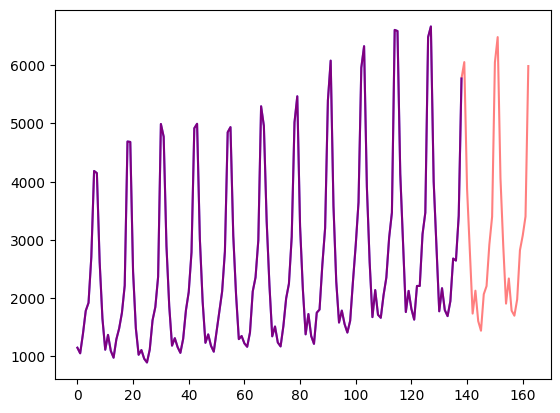

In [18]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [19]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [20]:
from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [21]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [22]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)